### Import Requirements

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
#from pandas.tools.plotting import table

#memory management
import gc

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib for plotting
import matplotlib.pyplot as plt

#to impute missing values
from sklearn.preprocessing import Imputer

### Set folder paths for getting input and saving outputs

In [2]:
#Set input data folder 
dataFolder = os.getcwd()+os.sep+os.pardir+os.sep+os.pardir+ os.sep + 'Home Credit Data'
if(not os.path.exists(dataFolder)):
    print("Input Data folder not found. Please specify data folder path as dataFolder variable to proceed")
    raise NotADirectoryError
    
#Create output folder is it does not exist
outputFolder = os.getcwd()+os.sep+os.pardir+os.sep+os.pardir+ os.sep + 'NoteBookOutputs'

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    print('Output Folder created')

### Read input file

In [3]:
# Read Training data
input_df = pd.read_csv(dataFolder + '\\application_train.csv')
print(input_df.shape)
input_df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test = pd.read_csv(dataFolder + '\\application_test.csv')
print(app_test.shape)
app_test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Check the difference in test and train file

In [14]:
input_df.columns.difference(app_test.columns)

Index(['TARGET'], dtype='object')

## Identify Feature types : Catagorical, Numerical, Integer and Boolean (Flags)

In [5]:
input_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [6]:
categorical_Features = list(input_df.select_dtypes(include='object'))
floatingPoint_Features = list(input_df.select_dtypes(include='float64'))
temp = list(input_df.select_dtypes(include='int64'))
bool_Features = [x for x in temp if 'FLAG' in x]
integer_Features = [x for x in temp if x not in bool_Features]
totalCount = len(categorical_Features) + len(floatingPoint_Features) + len(bool_Features) + len(integer_Features)
print ('Catagorical Features : {}, Floating Point Features : {}, Boolean Features : {}, Integer Features : {}, Total Count : {}'
       .format(len(categorical_Features), len(floatingPoint_Features), len(bool_Features), len(integer_Features), totalCount))

Catagorical Features : 16, Floating Point Features : 65, Boolean Features : 26, Integer Features : 15, Total Count : 122


## Check data imbalance

In [7]:
value_df = input_df['TARGET'].value_counts().to_frame().reset_index()
value_df.columns = ['Value', 'Count']
value_df['% of Total Values'] = [100 * value_df['Count'][0] / input_df.shape[0], 100 * value_df['Count'][1] / input_df.shape[0]]
value_df.head()

,Value,Count,% of Total Values
0,0,282686,91.927118
1,1,24825,8.072882


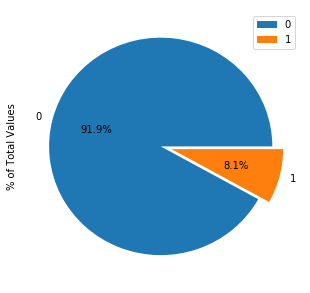

In [8]:
#Generate pie plot and save it in outputFolder
figure = value_df.plot.pie(y='% of Total Values', figsize= (5,5), explode=(0,0.1), autopct='%.1f%%').get_figure()
figure.savefig(outputFolder + os.sep + 'DataImbalance.png', dpi=200, format='png')

## Check For Missing Values

In [6]:
# Function to calculate missing values by columns 
def compute_missing_values(df, sortAscending = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=sortAscending).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing value information
        return mis_val_table_ren_columns

#### Save top and bottom 10 values in a csv. 

In [7]:
# Missing values statistics
missing_values = compute_missing_values(input_df)
missing_values.head(10).to_csv(outputFolder + os.sep + 'Top10MissingValues.csv')
missing_values.tail(10).to_csv(outputFolder + os.sep + 'Bottom10MissingValues.csv')

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


### Remove columns with greater than 20% missing values

In [8]:
missing_greater_than_20 = missing_values[missing_values.iloc[:,1] >= 20]
input_df = input_df.drop(columns=missing_greater_than_20.index)
print('{} columns have been dropped from input data set'.format(len(missing_greater_than_20)))
del missing_values
gc.collect()

50 columns have been dropped from input data set


7

## Outliers detection and handling

In [22]:
#Functions used for plotting and visualizing outliers

# add noise to y axis to avoid overlapping of data points
def rand_jitter(arr):
    nosie = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr))

def plot_feature_distribution(df, column, fileName = ''):
    column_values = df[df[column].notna()][column]
    # group by target
    class_0_values = df[df[column].notna() & (df['TARGET']==0)][column]
    class_1_values = df[df[column].notna() & (df['TARGET']==1)][column]
    class_t_values = df[df[column].notna() & (df['TARGET'].isna())][column]        
    # for features with unique values >= 10
    if len(df[column].value_counts().keys()) >= 10:
        fig, ax = plt.subplots(1, figsize=(15, 4))
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            label_encoder.fit(column_values)
            class_0_values = label_encoder.transform(class_0_values)
            class_1_values = label_encoder.transform(class_1_values)
            class_t_values = label_encoder.transform(class_t_values)
            column_values = label_encoder.transform(column_values)
            plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, fontsize=12, rotation='vertical')

        ax.scatter(class_0_values, rand_jitter([0]*class_0_values.shape[0]), label='Class0', s=10, marker='o', color='#7ac143', alpha=1)
        ax.scatter(class_1_values, rand_jitter([10]*class_1_values.shape[0]), label='Class1', s=10, marker='o', color='#fd5c63', alpha=1)
        ax.scatter(class_t_values, rand_jitter([20]*class_t_values.shape[0]), label='Test', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.set_title(column +' group by target', fontsize=16)
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        ax.set_title(column +' distribution', fontsize=16)
    else:      
        all_categories = list(df[df[column].notna()][column].value_counts().keys())
        bar_width = 0.25
        
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(column, fontsize=16)
        plt.xlabel('Categories', fontsize=16)
        plt.ylabel('Counts', fontsize=16)

        value_counts = class_0_values.value_counts()
        x_0 = np.arange(len(all_categories))
        y_0 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_0, y_0, color='#7ac143', width=bar_width, label='class0')

        value_counts = class_1_values.value_counts()
        x_1 = np.arange(len(all_categories))
        y_1 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_1+bar_width, y_1, color='#fd5c63', width=bar_width, label='class1')
        
        value_counts = class_t_values.value_counts()
        x_2 = np.arange(len(all_categories))
        y_2 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_2+2*bar_width, y_2, color='#037ef3', width=bar_width, label='test')
        
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
        for i, v in enumerate(y_0):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i - .08, max(y_0)//1.25,  "{:0.1f}%".format(100*y_0[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
        
        for i, v in enumerate(y_1):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i + bar_width - .08, max(y_0)//1.25, "{:0.1f}%".format(100*y_1[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
 
        for i, v in enumerate(y_2):
            if y_2[i] == 0:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, 'Missing in Test', fontsize=14, rotation='vertical')
            else:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, str(y_2[i]), fontsize=14, rotation='vertical')
        
        plt.xticks(x_0 + 2*bar_width/3, all_categories, fontsize=16)
        
    plt.show()
    plt.savefig(outputFolder + '\\{}{}_distribution.png'.format(column,fileName), bbox_inches='tight')
    plt.close()

In [18]:
#join train and test data sets for better visualization of outliers
combined_df = input_df.append(app_test)
print('Joined train rows {} with test rows {}. New total {}'.format(input_df.shape[0], app_test.shape[0],combined_df.shape[0]))

Joined train rows 307511 with test rows 48744. New total 356255


In [21]:
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED')

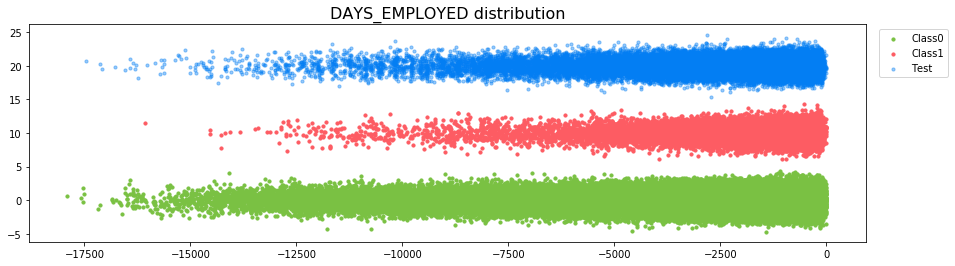

In [24]:
combined_df['DAYS_EMPLOYED'] = combined_df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED', '_corrected')

In [27]:
#Remove combined data frame to free up memory
del combined_df
gc.collect()

7

## Replace all the outliers in the input data set with nan

In [9]:
#Function to replace outliers in input data
def replace_outliers(df):
    #Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    if 'CODE_GENDER' in df:
        df = df[df['CODE_GENDER'] != 'XNA']

    #Replace outlier values with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].map(lambda x: x if x >= 0 else np.nan)
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 1e8 else np.nan)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].map(lambda x: x if x <= 10 else np.nan)
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 40 else np.nan)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 50 else np.nan)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 100 else np.nan)

In [10]:
replace_outliers(input_df)

## Data set version 1: with missing values as NaN

### Data set version 1_a: Null values without categorical features

In [31]:
#Version one with null values included and no categorical features.
categorical_features = list(input_df.select_dtypes(include='object'))
temp_df = input_df.drop(columns=categorical_features)
temp_df.to_csv(outputFolder + '\\DataSetVersion1_a.csv')
temp_df.info()
del temp_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
REGION_POPULATION_RELATIVE     307511 non-null float64
DAYS_BIRTH                     307511 non-null int64
DAYS_EMPLOYED                  307511 non-null int64
DAYS_REGISTRATION              307511 non-null float64
DAYS_ID_PUBLISH                307511 non-null int64
FLAG_MOBIL                     307511 non-null int64
FLAG_EMP_PHONE                 307511 non-null int64
FLAG_WORK_PHONE                307511 non-null int64
FLAG_CONT_MOBILE               307511 non-null int64
FLAG_PHONE                   

### Data set version 1_b: Null values with categorical features OHE

In [33]:
categorical_features = list(input_df.select_dtypes(include='object'))
temp_df = pd.get_dummies(input_df, columns=categorical_features, dtype=np.int64, dummy_na= True)
temp_df.to_csv(outputFolder + '\\DataSetVersion1_b.csv')
temp_df.info()
del temp_df, categorical_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 178 entries, SK_ID_CURR to ORGANIZATION_TYPE_nan
dtypes: float64(20), int64(158)
memory usage: 417.6 MB


### Data set version 1_c: Null values with categorical feature WOE encoded

In [28]:
#Function to caluculate WOE
def calculate_WOE(df, target,feature):
    lst = []
    for i in range(df[feature].nunique(dropna=False)):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (target == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (target == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    return data

In [36]:
categorical_features = list(input_df.select_dtypes(include='object'))

#Replace categorical columns with WOE columns
temp_df = input_df.copy()
for cat_feature in categorical_features:
    WoE_df = calculate_WOE(temp_df, 'TARGET', cat_feature)
    temp_df[cat_feature] = temp_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])

temp_df.to_csv(outputFolder + '\\DataSetVersion1_c.csv')
temp_df.info()
del temp_df, categorical_features, WoE_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null float64
CODE_GENDER                    307511 non-null float64
FLAG_OWN_CAR                   307511 non-null float64
FLAG_OWN_REALTY                307511 non-null float64
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
NAME_TYPE_SUITE                306219 non-null float64
NAME_INCOME_TYPE               307511 non-null float64
NAME_EDUCATION_TYPE            307511 non-null float64
NAME_FAMILY_STATUS             307511 non-null float64
NAME_HOUSING_TYPE              307511 non-null float64
REGION_POPULATI

In [35]:
a = temp_df[.isna()]
a['NAME_TYPE_SUITE'].head()

#temp_df = input_df.copy()
#print(temp_df['NAME_TYPE_SUITE'].nunique(dropna=False))
#print(temp_df['NAME_TYPE_SUITE'].unique())

#WoE_df = calculate_WOE(temp_df, 'TARGET', 'NAME_TYPE_SUITE')
#temp_df['NAME_TYPE_SUITE'] = temp_df['NAME_TYPE_SUITE'].replace(WoE_df.set_index('Value')['WoE'])


64     NaN
724    NaN
1199   NaN
1669   NaN
1862   NaN
Name: NAME_TYPE_SUITE, dtype: float64

## Data set version 2: With missing value entries omitted

### Data set version 2_a: Without categorical features 

In [58]:
#Version one with null values and categorical features.
categorical_features = list(input_df.select_dtypes(include='object'))
null_omitted_df = input_df.dropna().drop(columns=categorical_features)
null_omitted_df.to_csv(outputFolder + '\\DataSetVersion2_a.csv')
null_omitted_df.info()
del null_omitted_df categorical_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244280 entries, 0 to 307510
Data columns (total 61 columns):
SK_ID_CURR                     244280 non-null int64
TARGET                         244280 non-null int64
CNT_CHILDREN                   244280 non-null int64
AMT_INCOME_TOTAL               244280 non-null float64
AMT_CREDIT                     244280 non-null float64
AMT_ANNUITY                    244280 non-null float64
AMT_GOODS_PRICE                244280 non-null float64
REGION_POPULATION_RELATIVE     244280 non-null float64
DAYS_BIRTH                     244280 non-null int64
DAYS_EMPLOYED                  244280 non-null int64
DAYS_REGISTRATION              244280 non-null float64
DAYS_ID_PUBLISH                244280 non-null int64
FLAG_MOBIL                     244280 non-null int64
FLAG_EMP_PHONE                 244280 non-null int64
FLAG_WORK_PHONE                244280 non-null int64
FLAG_CONT_MOBILE               244280 non-null int64
FLAG_PHONE                   

### Data set version 2_b: With categorical features OHE

In [59]:
temp_df = input_df.dropna()
categorical_features = list(temp_df.select_dtypes(include='object'))
temp_df = pd.get_dummies(temp_df, columns=categorical_features, dtype=np.int64)
temp_df.to_csv(outputFolder + '\\DataSetVersion2_b.csv')
temp_df.info()
del temp_df, categorical_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244280 entries, 0 to 307510
Columns: 165 entries, SK_ID_CURR to ORGANIZATION_TYPE_XNA
dtypes: float64(20), int64(145)
memory usage: 309.4 MB


### Data set version 2_c: With categorical features WOE Encoded

In [38]:
#Replace categorical columns with WOE columns
temp_df = input_df.dropna()
categorical_features = list(temp_df.select_dtypes(include='object'))
for cat_feature in categorical_features:
    WoE_df = calculate_WOE(temp_df, 'TARGET', cat_feature)
    temp_df[cat_feature] = temp_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])

temp_df.to_csv(outputFolder + '\\DataSetVersion2_c.csv')
temp_df.info()
del temp_df, categorical_features, WoE_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244280 entries, 0 to 307510
Data columns (total 72 columns):
SK_ID_CURR                     244280 non-null int64
TARGET                         244280 non-null int64
NAME_CONTRACT_TYPE             244280 non-null float64
CODE_GENDER                    244280 non-null float64
FLAG_OWN_CAR                   244280 non-null float64
FLAG_OWN_REALTY                244280 non-null float64
CNT_CHILDREN                   244280 non-null int64
AMT_INCOME_TOTAL               244280 non-null float64
AMT_CREDIT                     244280 non-null float64
AMT_ANNUITY                    244280 non-null float64
AMT_GOODS_PRICE                244280 non-null float64
NAME_TYPE_SUITE                244280 non-null float64
NAME_INCOME_TYPE               244280 non-null float64
NAME_EDUCATION_TYPE            244280 non-null float64
NAME_FAMILY_STATUS             244280 non-null float64
NAME_HOUSING_TYPE              244280 non-null float64
REGION_POPULATI

## Data set version 3: With missing values imputed

### Data set version 3_a: Without categorical features

In [61]:
temp_df = input_df.dropna().drop(columns=list(input_df.select_dtypes(include='object')))

#Imputer for numerical features
imputer = Imputer(strategy = 'median')
imputer.fit_transform(temp_df)
    
temp_df.to_csv(outputFolder + '\\DataSetVersion3_a.csv')
temp_df.info()
del temp_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244280 entries, 0 to 307510
Data columns (total 61 columns):
SK_ID_CURR                     244280 non-null int64
TARGET                         244280 non-null int64
CNT_CHILDREN                   244280 non-null int64
AMT_INCOME_TOTAL               244280 non-null float64
AMT_CREDIT                     244280 non-null float64
AMT_ANNUITY                    244280 non-null float64
AMT_GOODS_PRICE                244280 non-null float64
REGION_POPULATION_RELATIVE     244280 non-null float64
DAYS_BIRTH                     244280 non-null int64
DAYS_EMPLOYED                  244280 non-null int64
DAYS_REGISTRATION              244280 non-null float64
DAYS_ID_PUBLISH                244280 non-null int64
FLAG_MOBIL                     244280 non-null int64
FLAG_EMP_PHONE                 244280 non-null int64
FLAG_WORK_PHONE                244280 non-null int64
FLAG_CONT_MOBILE               244280 non-null int64
FLAG_PHONE                   

### Data set version 3_b: With categorical features OHE

In [63]:
#Nominal variables imputed by mode values and Numerical variables imputed by mean
temp_df = input_df.copy()
# Categorical features with Binary encode (0 or 1; two categories)
for bool_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    if bool_feature in temp_df:
        temp_df[bool_feature], uniques = pd.factorize(temp_df[bool_feature])
        
categorical_Features = list(temp_df.select_dtypes(include='object'))
for cat_feature in categorical_Features:
    temp_df[cat_feature] = temp_df[cat_feature].fillna(temp_df[cat_feature].value_counts().index[0])
    
#Imputer for numerical features
imputer = Imputer(strategy = 'median')
    
numerical_features = list(temp_df.select_dtypes(exclude='object'))
for num_feature in numerical_features:
    imputer.fit(temp_df[num_feature].values.reshape(-1,1))
    temp_df[num_feature] = imputer.transform(temp_df[num_feature].values.reshape(-1,1))
    
temp_df = pd.get_dummies(temp_df, columns=categorical_Features, dtype=np.int64)
    
temp_df.to_csv(outputFolder + '\\DataSetVersion3_b.csv')
temp_df.info()
del temp_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 163 entries, SK_ID_CURR to ORGANIZATION_TYPE_XNA
dtypes: float64(64), int64(99)
memory usage: 382.4 MB


### Data set version 3_c: With categorical features WOE encoding

In [39]:
#Nominal variables imputed by mode values and Numerical variables imputed by mean
temp_df = input_df.copy()

categorical_features = list(temp_df.select_dtypes(include='object'))
for cat_feature in categorical_features:
    temp_df[cat_feature] = temp_df[cat_feature].fillna(temp_df[cat_feature].value_counts().index[0])
    
#Imputer for numerical features
imputer = Imputer(strategy = 'median')
    
numerical_features = list(temp_df.select_dtypes(exclude='object'))
for num_feature in numerical_features:
    imputer.fit(temp_df[num_feature].values.reshape(-1,1))
    temp_df[num_feature] = imputer.transform(temp_df[num_feature].values.reshape(-1,1))

#Replace categorical columns with WOE columns
for cat_feature in categorical_features:
    WoE_df = calculate_WOE(temp_df, 'TARGET', cat_feature)
    temp_df[cat_feature] = temp_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])
    del WoE_df

temp_df.to_csv(outputFolder + '\\DataSetVersion3_c.csv')
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
SK_ID_CURR                     307511 non-null float64
TARGET                         307511 non-null float64
NAME_CONTRACT_TYPE             307511 non-null float64
CODE_GENDER                    307511 non-null float64
FLAG_OWN_CAR                   307511 non-null float64
FLAG_OWN_REALTY                307511 non-null float64
CNT_CHILDREN                   307511 non-null float64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307511 non-null float64
AMT_GOODS_PRICE                307511 non-null float64
NAME_TYPE_SUITE                307511 non-null float64
NAME_INCOME_TYPE               307511 non-null float64
NAME_EDUCATION_TYPE            307511 non-null float64
NAME_FAMILY_STATUS             307511 non-null float64
NAME_HOUSING_TYPE              307511 non-null float64
REGION_PO

## Version 4: WOE for Catagorical Variables

In [41]:


input_df = pd.get_dummies(input_df, drop_first=True)

input_df.fillna(input_df.mean(axis = 1), inplace = True)

In [9]:
labels = input_df.pop('TARGET')

In [10]:
imputer = Imputer(strategy = 'median')
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Fit on the training data
imputer.fit(non_missing_df)
# Transform both training and testing data
non_missing_df = imputer.transform(non_missing_df)

scaler.fit(non_missing_df)

non_missing_df = scaler.transform(non_missing_df)

In [16]:
labels = np.asanyarray(labels)
   
if (labels.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(labels.sum())
    and not np.isfinite(labels).all()):
    print('Trouble')
else:
    print('All Good')


All Good


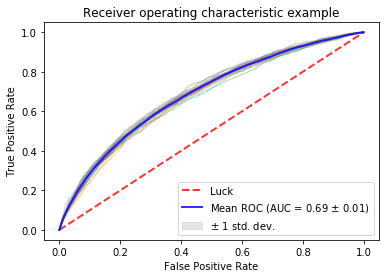

In [20]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=20)
log_reg = LogisticRegression(C = 0.001)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for trainSet, testSet in cv.split(non_missing_df, labels):
    model = log_reg.fit(non_missing_df[trainSet], labels[trainSet])
    probas_ = model.predict_proba(non_missing_df[testSet])

        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels[testSet], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jo

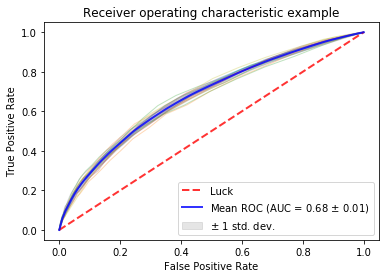

In [26]:
cv = StratifiedKFold(n_splits=20)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for trainSet, testSet in cv.split(non_missing_df, labels):
    model = random_forest.fit(non_missing_df[trainSet], labels[trainSet])
    probas_ = model.predict_proba(non_missing_df[testSet])

        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels[testSet], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.708717
[200]	valid_0's auc: 0.719996
[300]	valid_0's auc: 0.722943
[400]	valid_0's auc: 0.724805
[500]	valid_0's auc: 0.725394
[600]	valid_0's auc: 0.725927
[700]	valid_0's auc: 0.725814
Early stopping, best iteration is:
[598]	valid_0's auc: 0.725979
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.703621
[200]	valid_0's auc: 0.714046
[300]	valid_0's auc: 0.717494
[400]	valid_0's auc: 0.719573
[500]	valid_0's auc: 0.720807
[600]	valid_0's auc: 0.721879
[700]	valid_0's auc: 0.722175
[800]	valid_0's auc: 0.722364
[900]	valid_0's auc: 0.722371
[1000]	valid_0's auc: 0.722426
[1100]	valid_0's auc: 0.722387
Early stopping, best iteration is:
[920]	valid_0's auc: 0.722481
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.704836
[200]	valid_0's auc: 0.715882
[300]	valid_0's auc: 0.719595
[400]	valid_0's auc: 0.721287
[500]	valid_0's auc

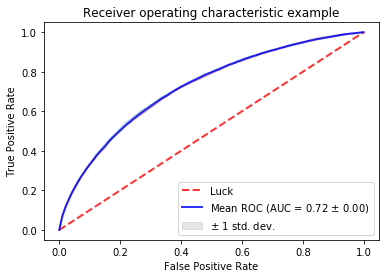

In [19]:
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )       
        
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
y = labels.values
for trainSet, testSet in cv.split(non_missing_df, y):
     
    clf.fit(non_missing_df[trainSet], y[trainSet], eval_set=[(non_missing_df[testSet], y[testSet])],
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)
    probas_ = clf.predict_proba(non_missing_df[testSet],  num_iteration=clf.best_iteration_)

        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[testSet], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [50]:
clf = LinearSVC(verbose = 100, max_iter = 200)
cv = StratifiedKFold(n_splits=7)

#feature_map_nystroem = Nystroem(gamma=.2, n_components= 200, random_state=1)
#features = feature_map_nystroem.fit_transform(non_missing_df)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
y = labels.values
for trainSet, testSet in cv.split(non_missing_df, y):
    clf.fit(non_missing_df[trainSet], y[trainSet])
    probas_ = clf.predict_proba(non_missing_df[testSet])

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[testSet], probas_[:])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[LibSVM]

ValueError: specified nu is infeasible